In [37]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib

import os
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from collections import deque

from tensorflow.keras.layers import Dropout

In [38]:
env = gym.make("FrozenLake-v1")
train_episodes=400
test_episodes=100
max_steps=700
state_size = env.observation_space.n
action_size = env.action_space.n
batch_size=2500

In [39]:
class Agent:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2500)
        self.learning_rate=0.85
        self.epsilon=1
        self.max_eps=1
        self.min_eps=0.01
        self.eps_decay = 0.001/3
        self.gamma=0.9
        self.state_size= state_size
        self.action_size= action_size
        self.epsilon_lst=[]
        self.model = self.buildmodel()

    def buildmodel(self):
        model=Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def add_memory(self, new_state, reward, done, state, action):
        self.memory.append((new_state, reward, done, state, action))

    def action(self, state):
        if np.random.rand() > self.epsilon:
            return np.random.randint(0,4)
        return np.argmax(self.model.predict(state))

    def pred(self, state):
        return np.argmax(self.model.predict(state))

    def replay(self,batch_size):
        minibatch=random.sample(self.memory, batch_size)
        for new_state, reward, done, state, action in minibatch:
            target= reward
            if not done:
                target=reward + self.gamma* np.amax(self.model.predict(new_state))
            target_f= self.model.predict(state)
            target_f[0][action]= target
            self.model.fit(state, target_f, epochs=3, verbose=0)

        if self.epsilon > self.min_eps:
            self.epsilon=(self.max_eps - self.min_eps) * np.exp(-self.eps_decay*episode) + self.min_eps

        self.epsilon_lst.append(self.epsilon)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

agent=Agent(state_size, action_size)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                544       
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 4)                 132       
                                                                 
Total params: 1,732
Trainable params: 1,732
Non-trainable params: 0
_________________________________________________________________


In [40]:
reward_lst=[]
for episode in range(train_episodes):
    state= env.reset()
    state_arr=np.zeros(state_size)
    state_arr[int(state[0])] = 1
    state= np.reshape(state_arr, [1, state_size])
    reward = 0
    done = False
    for t in range(max_steps):
        # env.render()
        action = agent.action(state)
        result = env.step(action)
        new_state = result[0]
        reward += result[1]  # Cộng dồn phần thưởng
        done = result[2]
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        agent.add_memory(new_state, reward, done, state, action)
        state= new_state

        if done:
            print(f'Episode: {episode:4}/{train_episodes} and step: {t:4}. Eps: {float(agent.epsilon):.2}, reward {reward}')
            break

    reward_lst.append(reward)

    if len(agent.memory)> batch_size:
        agent.replay(batch_size)

print(' Train mean % score= ', round(100*np.mean(reward_lst),1))

mean_reward = np.mean(reward_lst)
std_reward = np.std(reward_lst)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

1/1 [==============================] - 0s 26ms/step
Episode:    0/400 and step:    5. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 24ms/step
Episode:    1/400 and step:    2. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 28ms/step
Episode:    2/400 and step:    4. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 23ms/step
Episode:    3/400 and step:    3. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 38ms/step
Episode:    4/400 and step:    8. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 38ms/step
Episode:    5/400 and step:    1. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 33ms/step
Episode:    6/400 and step:    1. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 29ms/step
Episode:    7/400 and step:    7. Eps: 1.0, reward 0.0
1/1 [==============================] - 0s 33ms/step
Episode:    8/400 and step:    1. Eps: 1.0, reward 0.0
1/1 [==============================] 

In [41]:
# test
test_wins=[]
for episode in range(test_episodes):
    state = env.reset()
    state_arr=np.zeros(state_size)
    state_arr[int(state[0])] = 1
    state= np.reshape(state_arr, [1, state_size])
    done = False
    reward=0
    state_lst = []
    state_lst.append(state)
    print('******* EPISODE ',episode, ' *******')

    for step in range(max_steps):
        action = agent.pred(state)
        result = env.step(action)
        new_state = result[0]
        reward += result[1]  # Cộng dồn phần thưởng
        done = result[2]
        new_state_arr = np.zeros(state_size)
        new_state_arr[new_state] = 1
        new_state = np.reshape(new_state_arr, [1, state_size])
        state = new_state
        state_lst.append(state)
        if done:
            print(reward)
            # env.render()
            break

    test_wins.append(reward)
env.close()

print(' Test mean % score= ', int(100*np.mean(test_wins)))

******* EPISODE  0  *******
1/1 [==============================] - 0s 22ms/step
0.0
******* EPISODE  1  *******
1/1 [==============================] - 0s 23ms/step
0.0
******* EPISODE  2  *******
1/1 [==============================] - 0s 26ms/step
0.0
******* EPISODE  3  *******
1/1 [==============================] - 0s 25ms/step
0.0
******* EPISODE  4  *******
1/1 [==============================] - 0s 26ms/step
1.0
******* EPISODE  5  *******
1/1 [==============================] - 0s 28ms/step
0.0
******* EPISODE  6  *******
1/1 [==============================] - 0s 25ms/step
0.0
******* EPISODE  7  *******
1/1 [==============================] - 0s 26ms/step
0.0
******* EPISODE  8  *******
1/1 [==============================] - 0s 23ms/step
0.0
******* EPISODE  9  *******
1/1 [==============================] - 0s 23ms/step
0.0
******* EPISODE  10  *******
1/1 [==============================] - 0s 22ms/step
0.0
******* EPISODE  11  *******
1/1 [==============================] - 0s 24ms

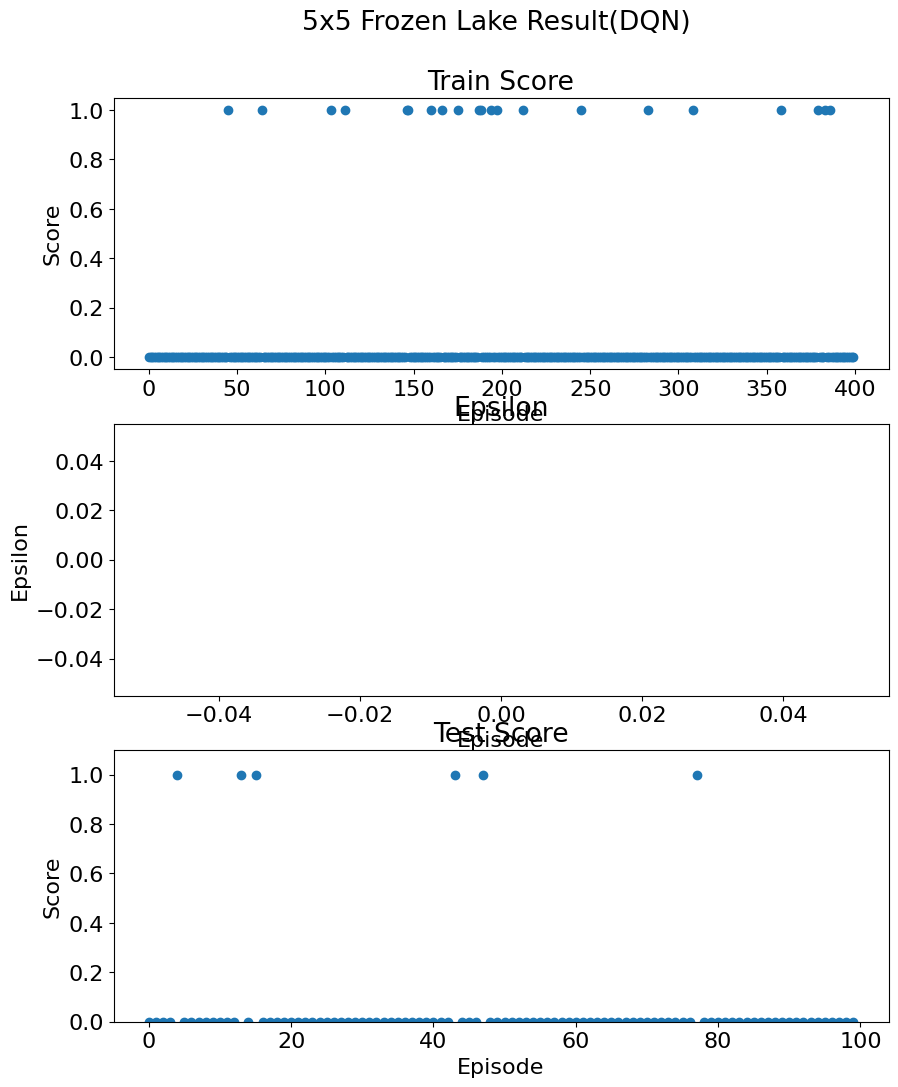

In [42]:
fig=plt.figure(figsize=(10,12))
matplotlib.rcParams.clear()
matplotlib.rcParams.update({'font.size': 16})
plt.subplot(311)
plt.scatter(list(range(len(reward_lst))), reward_lst)
plt.title('5x5 Frozen Lake Result(DQN) \n \nTrain Score')
plt.ylabel('Score')
plt.xlabel('Episode')

plt.subplot(312)
plt.scatter(list(range(len(agent.epsilon_lst))), agent.epsilon_lst)
plt.title('Epsilon')
plt.ylabel('Epsilon')
plt.xlabel('Episode')

plt.subplot(313)
plt.scatter(list(range(len(test_wins))), test_wins)
plt.title('Test Score')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.ylim((0,1.1))
plt.savefig('5x5resultdqn.png',dpi=300)
plt.show()